In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import *

import h5py

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams["image.origin"] = 'lower'

%matplotlib notebook

# hyperparameters
- encoder: 16 samples of 40 minutes, 1 interval 10 min, 1 every 4  --> 64 samples tstart
- decoder: 48 samples, 10 min == 8 hours

**Window of 114 samples**

Fighetterie per rinormalizzare input e output #fixme

In [4]:
decoder_input_and_true_v1 = np.load("../decoder_input_and_true_v1.npy",mmap_mode="r")
encoder_input_v1 = np.load("../encoder_input_v1.npy", mmap_mode="r")

In [5]:
decoder_input_data = decoder_input_and_true_v1[:, :, 0:-1]
decoder_target_data = decoder_input_and_true_v1[:, :, -1]
encoder_input_data = encoder_input_v1
decoder_target_data = np.reshape(decoder_target_data, (decoder_target_data.shape[0], decoder_target_data.shape[1],1))

In [43]:
initial_value = np.repeat(decoder_target_data[:,0,:], 48, axis=1).reshape((-1, 48, 1))
d = (decoder_target_data[:,:,:] - initial_value)/ initial_value

In [71]:
d.shape

(488520, 48, 1)

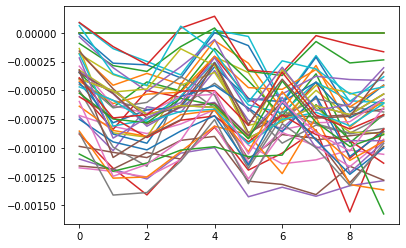

In [88]:
plt.plot(d[10:20,:,0])

In [95]:
minmax = MinMaxScaler(feature_range=(0,1))
std = StandardScaler()
qtr = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', ignore_implicit_zeros=False, subsample=100000, random_state=None, copy=True)

In [103]:
a = minmax.fit_transform(d[:10000,:,0])
dstd = std.fit_transform(d[:10000,:,0])
dq = qtr.fit_transform(d[:10000, :, 0])

<IPython.core.display.Javascript object>


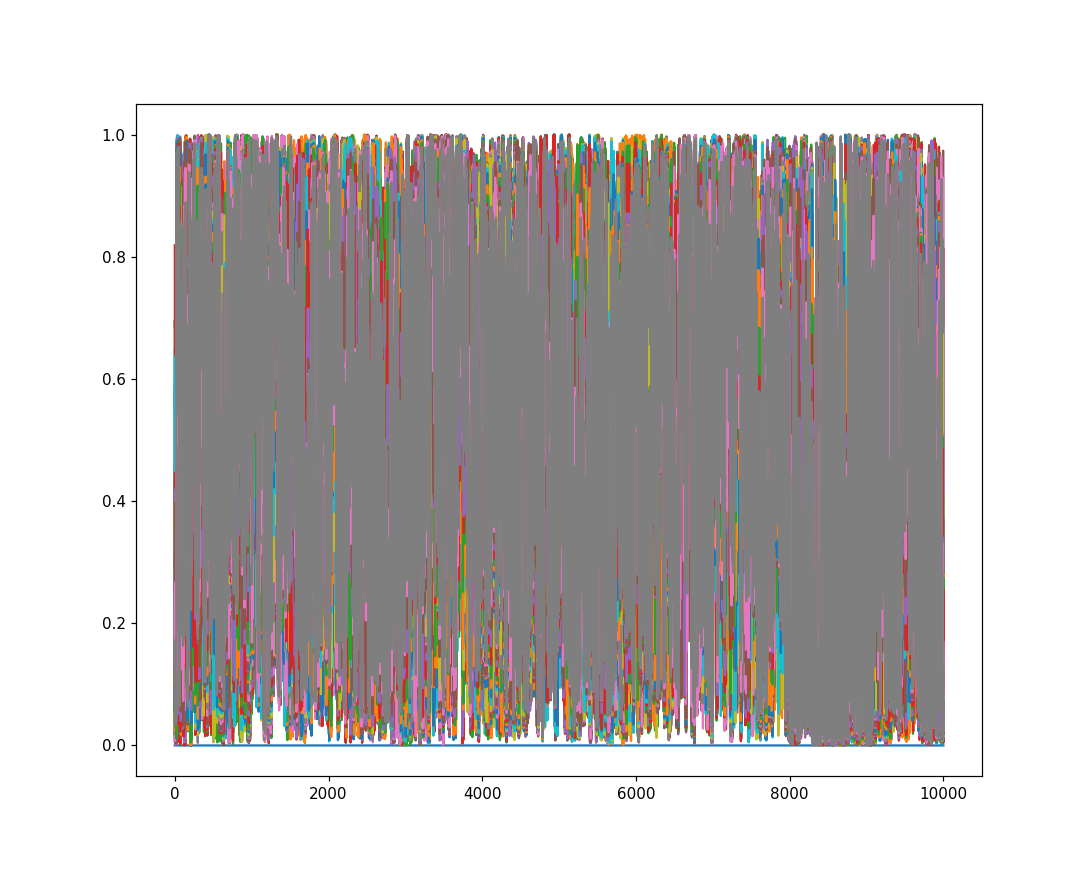

In [106]:
plt.plot(dq)

In [ ]:
plt.plot(b)

In [4]:
def get_scalers():
    # scalers
    encoder_scaler = StandardScaler()
    decoder_input_scaler = StandardScaler()
    decoder_target_scaler = StandardScaler()
    
    encoder_scaler.fit(encoder_input_data.reshape((encoder_input_data.shape[0]*encoder_input_data.shape[1], encoder_input_data.shape[2]))[:10000,])
    decoder_input_scaler.fit(decoder_input_data.reshape((decoder_input_data.shape[0]*decoder_input_data.shape[1], decoder_input_data.shape[2]))[:10000,])
    decoder_target_scaler.fit(decoder_target_data.reshape((decoder_target_data.shape[0]*decoder_target_data.shape[1],decoder_target_data.shape[2]))[:10000,])

    return encoder_scaler, decoder_input_scaler,  decoder_target_scaler

In [19]:
def rescale(scaler, arr):
    return scaler.transform(arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2])))\
                        .reshape((-1, arr.shape[1], arr.shape[2]),  order="C")

In [15]:
print("decoder input shape", decoder_input_data.shape)
print("decoder target shape", decoder_target_data.shape)
print("encoder input shape", encoder_input_data.shape)

decoder input shape (488520, 48, 11)
decoder target shape (488520, 48, 1)
encoder input shape (488520, 16, 11)


In [20]:
encoder_scaler , decoder_input_scaler , decoder_target_scaler  = get_scalers()

In [21]:
encoder_input_scaled = rescale(encoder_scaler, encoder_input_data)

In [22]:
decoder_input_scaled = rescale(decoder_input_scaler, decoder_input_data)
decoder_target_scaled = rescale(decoder_target_scaler, decoder_target_data)

# Definition of the model

In [28]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Flatten

Using TensorFlow backend.


In [29]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = len(encoder_input_v1)
encoder_input_dim = encoder_input_data.shape[2]
decoder_input_dim = decoder_input_data.shape[2]

# Define an input sequence and process it.
encoder_inputs = Input(shape=(16, encoder_input_dim))
encoder = LSTM(latent_dim, return_state=True, input_shape=(batch_size, 16, 11))
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, decoder_input_dim))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim,input_shape=(batch_size, 48, 11), return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = TimeDistributed(Dense(1, activation='sigmoid'))

decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



W1010 17:08:31.617232 139620837443392 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 17:08:31.643406 139620837443392 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 17:08:31.649806 139620837443392 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [17]:
from keras.utils import plot_model
plot_model(model, to_file='model.dot',show_shapes=True)

In [32]:
# Run training
model.compile(optimizer='adam', loss='MSE',
              metrics=['mean_squared_error'])
model.fit([encoder_input_scaled[:10000,], decoder_input_scaled[:10000,]], decoder_target_scaled[:10000,],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('model_test1.h5')



Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 35s 4ms/step - loss: 0.8563 - mean_squared_error: 0.8563 - val_loss: 1.3351 - val_mean_squared_error: 1.3351
Epoch 2/100
8000/8000 [==============================] - 34s 4ms/step - loss: 0.7492 - mean_squared_error: 0.7492 - val_loss: 1.3533 - val_mean_squared_error: 1.3533
Epoch 3/100
8000/8000 [==============================] - 33s 4ms/step - loss: 0.7477 - mean_squared_error: 0.7477 - val_loss: 1.3063 - val_mean_squared_error: 1.3063
Epoch 4/100
8000/8000 [==============================] - 34s 4ms/step - loss: 0.7478 - mean_squared_error: 0.7478 - val_loss: 1.2562 - val_mean_squared_error: 1.2562
Epoch 5/100
1088/8000 [===>..........................] - ETA: 27s - loss: 0.7884 - mean_squared_error: 0.7884

KeyboardInterrupt: 